# Notebook: embeddings-textos-breve-cacic2024.ipynb
#### Versión resumida de las tareas descriptas en la primera parte de la clase, vinculadas a los embeddings de tokens estáticos y contextualizados y los embeddings de sentencias


In [ ]:
import torch
# OPTIONAL: if you want to have more information on what's happening, activate the logger as follows
import logging
#logging.basicConfig(level=logging.INFO)

import numpy as np
from sklearn.decomposition import PCA
import seaborn as sns
import pandas as pd
import scipy

from transformers import BertTokenizer, BertModel
from sklearn.metrics.pairwise import cosine_similarity

import matplotlib.pyplot as plt
%matplotlib inline

!pip install datasets
from datasets import load_dataset


INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 5.1 MB/s eta 0:00:00


## 1) Representación de tokens/palabras
Se ejemplifican distintas formas de representación de tokens, estáticas y contextualizadas




### 1.1) Embeddings estáticos (Word2vec, Fastext, Glove)

#### Introducción al uso de la API de Gensim

Existen innumerables sitios web y repositorios que ofrecen diversos conjuntos de datos (data sets) para el aprendizaje automático y modelos entrenados previamente (Kaggle, UCI MLR, DeepDive, repositorios individuales para gloVe, FastText, etc), El único problema es que todos utilizan formatos muy diferentes, cubren casos de uso muy diferentes y suelen quedar desactualizados muy rápidamente.

Por este motivo, Gensim ha hecho disponible en forma directa **conjuntos de datos y modelos** gratuitos relevantes para el análisis de texto no supervisado (el punto fuerte de Gensim), utilizando un repositorio de datos estable en  [Github](https://github.com/RaRe-Technologies/gensim-data), con un formato de datos y una API de acceso unificados. Así, Gensim que existe desde hace más de 10 años, cuenta con su propio conjunto de recursos estables y confiables.

Una de las cosas que se puede con esta API, es descargar los vectores de palabras (embeddings) aprendidos con un algoritmo de aprendizaje automático como GloVe. A modo de ejemplo, podemos acceder los vectores (embeddings) aprendidos por GloVe con datos de Wikipedia:

In [ ]:
import gensim.downloader as api
word_vectors = api.load('glove-wiki-gigaword-100')
#word_vectors = api.load('word2vec-google-news-300') # En caso que quiciera trabajar con embeddings word2vec mas grandes

[==================================================] 100.0% 128.1/128.1MB downloaded


In [ ]:
word_vectors['king'].shape

(100,)

In [ ]:
word_vectors['king'][:20]

array([-0.32307 , -0.87616 ,  0.21977 ,  0.25268 ,  0.22976 ,  0.7388  ,
       -0.37954 , -0.35307 , -0.84369 , -1.1113  , -0.30266 ,  0.33178 ,
       -0.25113 ,  0.30448 , -0.077491, -0.89815 ,  0.092496, -1.1407  ,
       -0.58324 ,  0.66869 ], dtype=float32)

In [ ]:
# Las palabras a visualizar
words = ["king", "princess", "monarch", "throne", "crown",
         "mountain", "ocean", "tv", "rainbow", "cloud", "queen"]

# Get word vectors
vectors = np.array([word_vectors[word] for word in words])

In [ ]:
# Reducir dimensiones usando PCA
pca = PCA(n_components=2)
vectors_pca = pca.fit_transform(vectors)

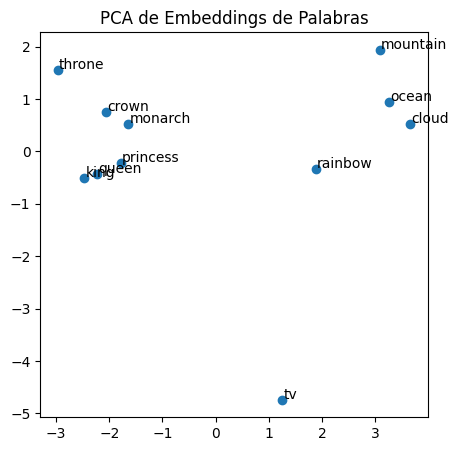

In [ ]:
# Plotting
fig, axes = plt.subplots(1, 1, figsize=(5, 5))
axes.scatter(vectors_pca[:, 0], vectors_pca[:, 1])
for i, word in enumerate(words):
    axes.annotate(word, (vectors_pca[i, 0]+.02, vectors_pca[i, 1]+.02))
axes.set_title('PCA de Embeddings de Palabras')
plt.show()

Podemos realizar distintas consultas con los embeddings utilizando el método most_similar(), como aquella que me permite calcular: (king - man) + woman = ?. Distintas variantes del uso de este método se ven a continuación.

In [ ]:
# calcular: (king - man) + woman = ?
result = word_vectors.most_similar(positive=['king', 'woman'],
                                   negative=['man'], topn=1)

# Mostrar el resultado
print(f"""
    La palabra más cercana a 'king' - 'man' + 'woman' es: '{result[0][0]}'
    con un valor de similitud de {result[0][1]}""")


    La palabra más cercana a 'king' - 'man' + 'woman' es: 'queen'
    con un valor de similitud de 0.7698540687561035


In [ ]:
word_vectors.most_similar('obama')

[('barack', 0.937216579914093),
 ('bush', 0.927285373210907),
 ('clinton', 0.896000325679779),
 ('mccain', 0.8875633478164673),
 ('gore', 0.8000321388244629),
 ('hillary', 0.7933662533760071),
 ('dole', 0.7851964831352234),
 ('rodham', 0.7518897652626038),
 ('romney', 0.7488929629325867),
 ('kerry', 0.7472624182701111)]

In [ ]:
word_vectors.most_similar('banana')

[('coconut', 0.7097253203392029),
 ('mango', 0.7054824829101562),
 ('bananas', 0.6887733340263367),
 ('potato', 0.6629636287689209),
 ('pineapple', 0.6534532308578491),
 ('fruit', 0.6519854664802551),
 ('peanut', 0.6420575976371765),
 ('pecan', 0.6349173188209534),
 ('cashew', 0.6294420957565308),
 ('papaya', 0.6246591210365295)]

In [ ]:
word_vectors.most_similar(negative='banana')

[('shunichi', 0.49618104100227356),
 ('ieronymos', 0.4736502170562744),
 ('pengrowth', 0.4668096601963043),
 ('höss', 0.4636845588684082),
 ('damaskinos', 0.4617849290370941),
 ('yadin', 0.4617374837398529),
 ('hundertwasser', 0.4588957726955414),
 ('ncpa', 0.4577339291572571),
 ('maccormac', 0.4566109776496887),
 ('rothfeld', 0.4523947238922119)]

In [ ]:
def analogia(x1, x2, y1):
    result = word_vectors.most_similar(positive=[y1, x2], negative=[x1])
    print(x2 + " es a " + x1 + " lo que " + result[0][0] + " es a " + y1)
    return result[0][0]

In [ ]:
analogia('japan', 'japanese', 'australia')

japanese es a japan lo que australian es a australia


'australian'

In [ ]:
analogia('australia', 'beer', 'france')

beer es a australia lo que champagne es a france


'champagne'

In [ ]:
analogia('obama', 'clinton', 'reagan')

clinton es a obama lo que nixon es a reagan


'nixon'

In [ ]:
analogia('tall', 'tallest', 'long')

tallest es a tall lo que longest es a long


'longest'

In [ ]:
analogia('good', 'fantastic', 'bad')

fantastic es a good lo que terrible es a bad


'terrible'

También podemos ver la palabras que no se parece a las restantes palabras

In [ ]:
print(word_vectors.doesnt_match("breakfast cereal dinner lunch".split()))

cereal


In [ ]:
print(word_vectors.doesnt_match("breakfast money dinner lunch".split()))

money


In [ ]:
print(word_vectors.doesnt_match("apple banana orange car".split()))

car


In [ ]:
import numpy as np
from sklearn.decomposition import PCA

def display_pca_scatterplot(model, words=None, sample=0):
    if words == None:
        if sample > 0:
            words = np.random.choice(list(model.vocab.keys()), sample)
        else:
            words = [word for word in model.key_to_index]

    embeddings = np.array([model[w] for w in words])

    twodim = PCA().fit_transform(embeddings)[:,:2]
    #twodim = PCA(n_components=2).fit_transform(embeddings)


    plt.figure(figsize=(6,6))
    plt.scatter(twodim[:,0], twodim[:,1], edgecolors='k', c='r')
    for word, (x,y) in zip(words, twodim):
        plt.text(x+0.05, y+0.05, word)

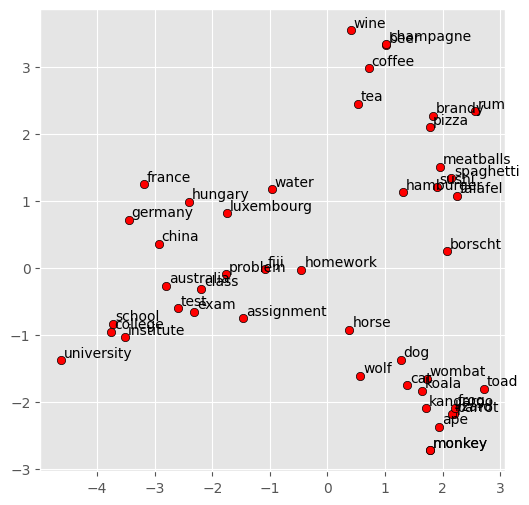

In [ ]:
# Get the interactive Tools for Matplotlib
#%matplotlib notebook
import matplotlib.pyplot as plt
plt.style.use('ggplot')


display_pca_scatterplot(word_vectors,
                        ['coffee', 'tea', 'beer', 'wine', 'brandy', 'rum', 'champagne', 'water',
                         'spaghetti', 'borscht', 'hamburger', 'pizza', 'falafel', 'sushi', 'meatballs',
                         'dog', 'horse', 'cat', 'monkey', 'parrot', 'koala', 'lizard',
                         'frog', 'toad', 'monkey', 'ape', 'kangaroo', 'wombat', 'wolf',
                         'france', 'germany', 'hungary', 'luxembourg', 'australia', 'fiji', 'china',
                         'homework', 'assignment', 'problem', 'exam', 'test', 'class',
                         'school', 'college', 'university', 'institute'])


### 1.2) Embeddings contextualizados (BERT)

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Función para obtener los embeddings con BERT
def get_bert_embeddings(sentence, word):
    inputs = tokenizer(sentence, return_tensors='pt') # Ver https://huggingface.co/docs/transformers/main_classes/tokenizer para más detalles
    outputs = model(**inputs)
    last_hidden_states = outputs.last_hidden_state
    word_tokens = tokenizer.tokenize(sentence)
    word_index = word_tokens.index(word)
    word_embedding = last_hidden_states[0, word_index + 1, :]  # +1 para contar el token [CLS]
    return word_embedding

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
sentence1 = "The bat flew out of the cave at night."
sentence2 = "He swung the bat and hit a home run."

word = "bat"

bert_embedding1 = get_bert_embeddings(sentence1, word).detach().numpy()
bert_embedding2 = get_bert_embeddings(sentence2, word).detach().numpy()
word_embedding = word_vectors[word]

In [ ]:
print("Embedding de BERT  para 'bat' en la sentencia: - The bat flew out of the cave at night.- :", bert_embedding1[:5])
print("Embedding de BERT  para 'bat' en la sentencia: - He swung the bat and hit a home run.- :", bert_embedding2[:5])
print("Embedding de GloVe para 'bat':", word_embedding[:5])

bert_similarity = cosine_similarity([bert_embedding1], [bert_embedding2])[0][0]
word_embedding_similarity = cosine_similarity([word_embedding], [word_embedding])[0][0]

print()
print(f"Similitud coseno entre embeddings de BERT en diferentes contextos: {bert_similarity}")
print(f"Similitud coseno entre embeddings de Glove: {word_embedding_similarity}")


Embedding de BERT  para 'bat' en la sentencia: - The bat flew out of the cave at night.- : [ 0.4131613  -0.12908208 -0.44865727 -0.40492675 -0.15305734]
Embedding de BERT  para 'bat' en la sentencia: - He swung the bat and hit a home run.- : [ 0.64066994 -0.31121498 -0.44089845 -0.16551109 -0.2005611 ]
Embedding de GloVe para 'bat': [-0.47601  0.81705  0.11151 -0.22687 -0.80672]

Similitud coseno entre embeddings de BERT en diferentes contextos: 0.459957480430603
Similitud coseno entre embeddings de Glove: 1.0


### En español

In [ ]:
tokenizer = BertTokenizer.from_pretrained('dccuchile/bert-base-spanish-wwm-uncased')
model = BertModel.from_pretrained('dccuchile/bert-base-spanish-wwm-uncased')

tokenizer_config.json:   0%|          | 0.00/310 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/248k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/134 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/486k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/650 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
sentencia1 = "La llama bajaba de la montaña para comer el pasto."
sentencia2 = "Encendió el fuego y el resplandor de la llama le iluminaba la cara."

palabra = "llama"

beto_embedding1 = get_bert_embeddings(sentencia1, palabra).detach().numpy()
beto_embedding2 = get_bert_embeddings(sentencia2, palabra).detach().numpy()
# word_embedding = word_vectors[word]

In [ ]:
print("Embedding de BETO para 'llama' en la sentencia 1:", beto_embedding1[:5])
print("Embedding de BETO para 'llama' en la sentencia 2:", beto_embedding2[:5])
# print("GloVe Embedding for 'bat':", word_embedding[:5])

beto_similarity = cosine_similarity([beto_embedding1], [beto_embedding2])[0][0]
# word_embedding_similarity = cosine_similarity([word_embedding], [word_embedding])[0][0]

print()
print(f"Similitud coseno entre embeddings de BETO en diferentes contextos: {beto_similarity}")
# print(f"Cosine Similarity between GloVe embeddings: {word_embedding_similarity}")


Embedding de BETO para 'llama' en la sentencia 1: [ 0.5076061  -0.6813269   0.80980736 -0.1363263   0.2566918 ]
Embedding de BETO para 'llama' en la sentencia 2: [ 0.10288442 -0.5967249  -0.9830319   0.73763067  0.17018099]

Similitud coseno entre embeddings de BETO en diferentes contextos: 0.6892995834350586


## 2) Representación de sentencias


### 2.1) Agregación de embeddings de tokens

Trabajaremos primero con el modelo en inglés

In [ ]:
model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


La función ```get_sentence_embedding``` obtiene los embeddings de los tokens de la última capa de BERT y realiza un promedio (mean pooling) de los mismos

In [ ]:
def get_sentence_embedding(sentence):
    encoded_input = tokenizer(sentence, padding=True, truncation=True, return_tensors='pt')
    attention_mask = encoded_input['attention_mask']   # para indicar cuales tokens son válidos y cuales relleno (padding)

    # Obtener la salida del modelo (sin la cabeza de clasificación específica)
    with torch.no_grad():
        output = model(**encoded_input)

    token_embeddings = output.last_hidden_state
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()

    # operación de mean pooling, considerando la input_mask y padding de BERT
    sentence_embedding = torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

    return sentence_embedding.flatten().tolist()

In [ ]:
def cosine_similarity_matrix(features):
    norms = np.linalg.norm(features, axis=1, keepdims=True)
    normalized_features = features / norms
    similarity_matrix = np.inner(normalized_features, normalized_features)
    rounded_similarity_matrix = np.round(similarity_matrix, 4)
    return rounded_similarity_matrix

In [ ]:
# Helper function to plot similarity matrix
def plot_similarity(labels, features, rotation):
    sim = cosine_similarity_matrix(features)
    sns.set_theme(font_scale=1.2)
    g = sns.heatmap(sim, xticklabels=labels, yticklabels=labels, vmin=0, vmax=1, cmap="YlOrRd")
    g.set_xticklabels(labels, rotation=rotation)
    g.set_title("Semantic Textual Similarity")
    return g

## Mensajes a comparar su similitud

In [ ]:
messages = [
    # Smartphones
    "I like my phone",
    "My phone is not good.",
    "Your cellphone looks great.",

    # Weather
    "Will it snow tomorrow?",
    "Recently a lot of hurricanes have hit the US",
    "Global warming is real",

    # Food and health
    "An apple a day, keeps the doctors away",
    "Eating strawberries is healthy",
    "Is paleo better than keto?",

    # Asking about age
    "How old are you?",
    "what is your age?",
]

<Axes: title={'center': 'Semantic Textual Similarity'}>

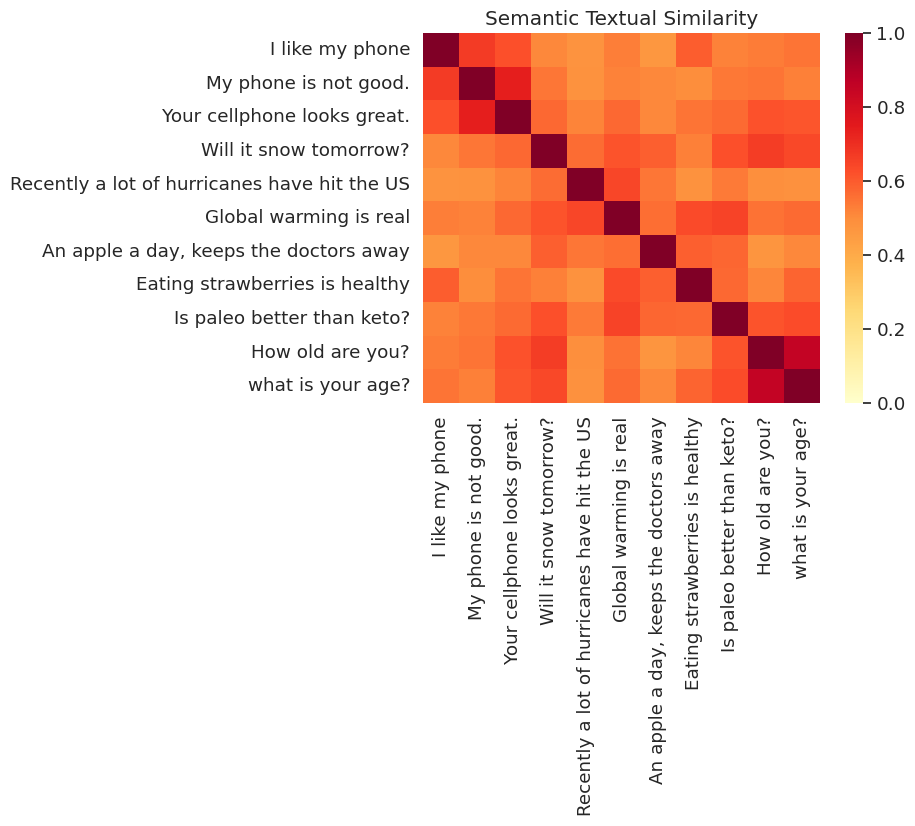

In [ ]:
embeddings = []
for t in messages:
    emb = get_sentence_embedding(t)
    embeddings.append(emb)

plot_similarity(messages, embeddings, 90)

#### Compararemos con los valores etiquetados manualmente (dataset stsbenchmark-sts)

In [ ]:
sts_dataset = load_dataset("mteb/stsbenchmark-sts")
sts = pd.DataFrame({'sent1': sts_dataset['test']['sentence1'],
                    'sent2': sts_dataset['test']['sentence2'],
                    'score': [x/5 for x in sts_dataset['test']['score']]})
sts.head(10)

README.md:   0%|          | 0.00/22.0 [00:00<?, ?B/s]

train.jsonl.gz:   0%|          | 0.00/278k [00:00<?, ?B/s]

validation.jsonl.gz:   0%|          | 0.00/86.4k [00:00<?, ?B/s]

test.jsonl.gz:   0%|          | 0.00/63.2k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/5749 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1500 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1379 [00:00<?, ? examples/s]

,sent1,sent2,score
0,A girl is styling her hair.,A girl is brushing her hair.,0.5000
1,A group of men play soccer on the beach.,A group of boys are playing soccer on the beach.,0.7200
2,One woman is measuring another woman's ankle.,A woman measures another woman's ankle.,1.0000
3,A man is cutting up a cucumber.,A man is slicing a cucumber.,0.8400
4,A man is playing a harp.,A man is playing a keyboard.,0.3000
5,A woman is cutting onions.,A woman is cutting tofu.,0.3600
6,A man is riding an electric bicycle.,A man is riding a bicycle.,0.7000
7,A man is playing the drums.,A man is playing the guitar.,0.4400
8,A man is playing guitar.,A lady is playing the guitar.,0.4400
9,A man is playing a guitar.,A man is playing a trumpet.,0.3428


<b>Acerca de las puntuaciones (scores) asignadas en STS</b>: Estas puntuaciones se basan en evaluaciones humanas y están en el rango de 0 a 5 (consulte la tabla 1 de https://aclanthology.org/S17-2001.pdf para ver cómo funcionan). Por ejemplo, "A woman is cutting onions" versus "A woman is cutting tofu" puede ser considerado por un humano entre 2 y 3 aproximadamente. El objetivo de STS es más bien mostrar otro ejemplo en el que, en lugar de sólo nuestra intuición, hay algún tipo de conjunto de datos etiquetados por humanos, aunque no es exactamente una similitud en el sentido del coseno, sino de acuerdo con las reglas de la tabla 1 del artículo anterior.

In [ ]:
def sim_two_sentences(s1, s2):
    emb1 = get_sentence_embedding(s1)
    emb2 = get_sentence_embedding(s2)
    sim = cosine_similarity_matrix(np.vstack([emb1, emb2]))
    return sim[0,1]

n_examples = 50

sts = sts.head(n_examples)
sts['avg_bert_score'] = np.vectorize(sim_two_sentences) \
                                    (sts['sent1'], sts['sent2'])

In [ ]:
sts.head(10)

,sent1,sent2,score,avg_bert_score
0,A girl is styling her hair.,A girl is brushing her hair.,0.5000,0.9767
1,A group of men play soccer on the beach.,A group of boys are playing soccer on the beach.,0.7200,0.9615
2,One woman is measuring another woman's ankle.,A woman measures another woman's ankle.,1.0000,0.9191
3,A man is cutting up a cucumber.,A man is slicing a cucumber.,0.8400,0.9763
4,A man is playing a harp.,A man is playing a keyboard.,0.3000,0.9472
5,A woman is cutting onions.,A woman is cutting tofu.,0.3600,0.8787
6,A man is riding an electric bicycle.,A man is riding a bicycle.,0.7000,0.9793
7,A man is playing the drums.,A man is playing the guitar.,0.4400,0.9730
8,A man is playing guitar.,A lady is playing the guitar.,0.4400,0.9519
9,A man is playing a guitar.,A man is playing a trumpet.,0.3428,0.9588


In [ ]:
pc = scipy.stats.pearsonr(sts['score'], sts['avg_bert_score'])
print(f'Pearson correlation coefficient = {pc[0]}\np-value = {pc[1]}')

Pearson correlation coefficient = 0.32100172202695465
p-value = 0.02303013509739929


### 2.2) Sentence-Transformers (S-BERT)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.3/245.3 kB 4.9 MB/s eta 0:00:00


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

<Axes: title={'center': 'Semantic Textual Similarity'}>

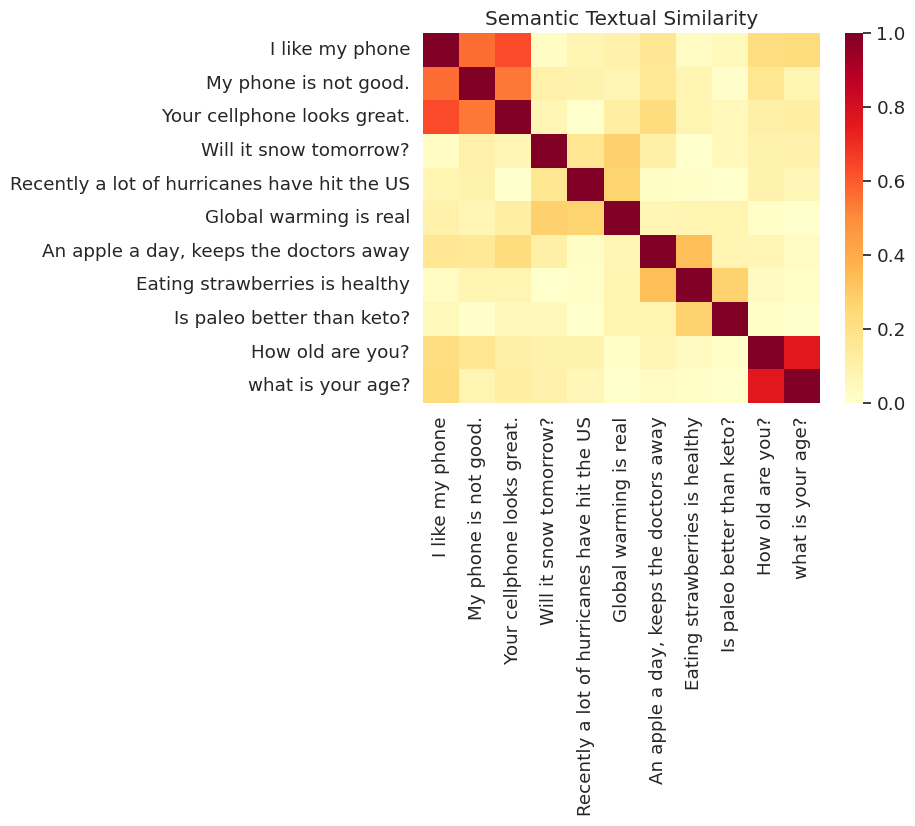

In [ ]:
!pip install sentence_transformers
from sentence_transformers import SentenceTransformer
model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")
embeddings = []
for t in messages:
    emb = list(model.encode(t))
    embeddings.append(emb)

plot_similarity(messages, embeddings, 90)

In [ ]:
def sim_two_sentences(s1, s2):
    emb1 = list(model.encode(s1))
    emb2 = list(model.encode(s2))
    sim = cosine_similarity_matrix(np.vstack([emb1, emb2]))
    return sim[0,1]

sts['mini_LM_score'] = np.vectorize(sim_two_sentences)(sts['sent1'], sts['sent2'])
sts.head(10)

,sent1,sent2,score,avg_bert_score,mini_LM_score
0,A girl is styling her hair.,A girl is brushing her hair.,0.5000,0.9767,0.8052
1,A group of men play soccer on the beach.,A group of boys are playing soccer on the beach.,0.7200,0.9615,0.7886
2,One woman is measuring another woman's ankle.,A woman measures another woman's ankle.,1.0000,0.9191,0.9465
3,A man is cutting up a cucumber.,A man is slicing a cucumber.,0.8400,0.9763,0.8820
4,A man is playing a harp.,A man is playing a keyboard.,0.3000,0.9472,0.3556
5,A woman is cutting onions.,A woman is cutting tofu.,0.3600,0.8787,0.5017
6,A man is riding an electric bicycle.,A man is riding a bicycle.,0.7000,0.9793,0.8074
7,A man is playing the drums.,A man is playing the guitar.,0.4400,0.9730,0.4757
8,A man is playing guitar.,A lady is playing the guitar.,0.4400,0.9519,0.6182
9,A man is playing a guitar.,A man is playing a trumpet.,0.3428,0.9588,0.5096


In [ ]:
pc = scipy.stats.pearsonr(sts['score'], sts['mini_LM_score'])
print(f'Pearson correlation coefficient = {pc[0]}\np-value = {pc[1]}')

Pearson correlation coefficient = 0.9303740673726043
p-value = 1.4823857251915091e-22


### Español

In [ ]:
mensajes = [
    # Smartphones
    "Mi teléfono móvil me gusta.",
    "Mi teléfono móvil no es bueno",
    "Tu teléfono celular luce grandioso.",

    # Weather
    "¿Mañana nevará?",
    "Recientemente muchos huracanes han golpeado los US",
    "El calentamiento global es real",

    # Food and health
    "Una manzana al día mantiene alejado a los doctores",
    "Comer frutillas es saludable",
    "¿Es la dieta paleo mejor que la keto?",

    # Asking about age
    "¿Cuantos años tienes?",
    "¿Cual es tu edad?",
]

In [ ]:
model_name = "dccuchile/bert-base-spanish-wwm-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of BertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<Axes: title={'center': 'Semantic Textual Similarity'}>

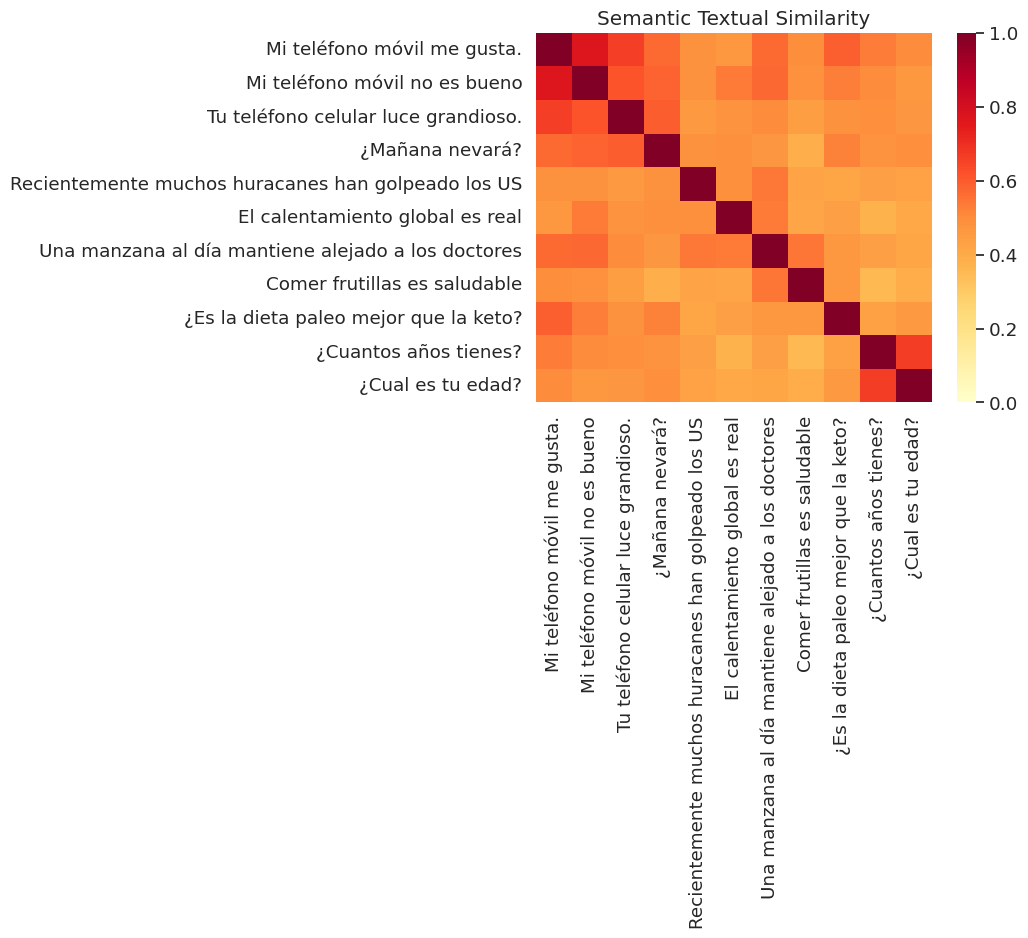

In [ ]:
embeddings_espa = []
for t in mensajes:
    emb = get_sentence_embedding(t)
    embeddings_espa.append(emb)

plot_similarity(mensajes, embeddings_espa, 90)

### Sentence-Transformers (Español)

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/123 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/4.51k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/701 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/439M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/556 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/242k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/480k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

<Axes: title={'center': 'Semantic Textual Similarity'}>

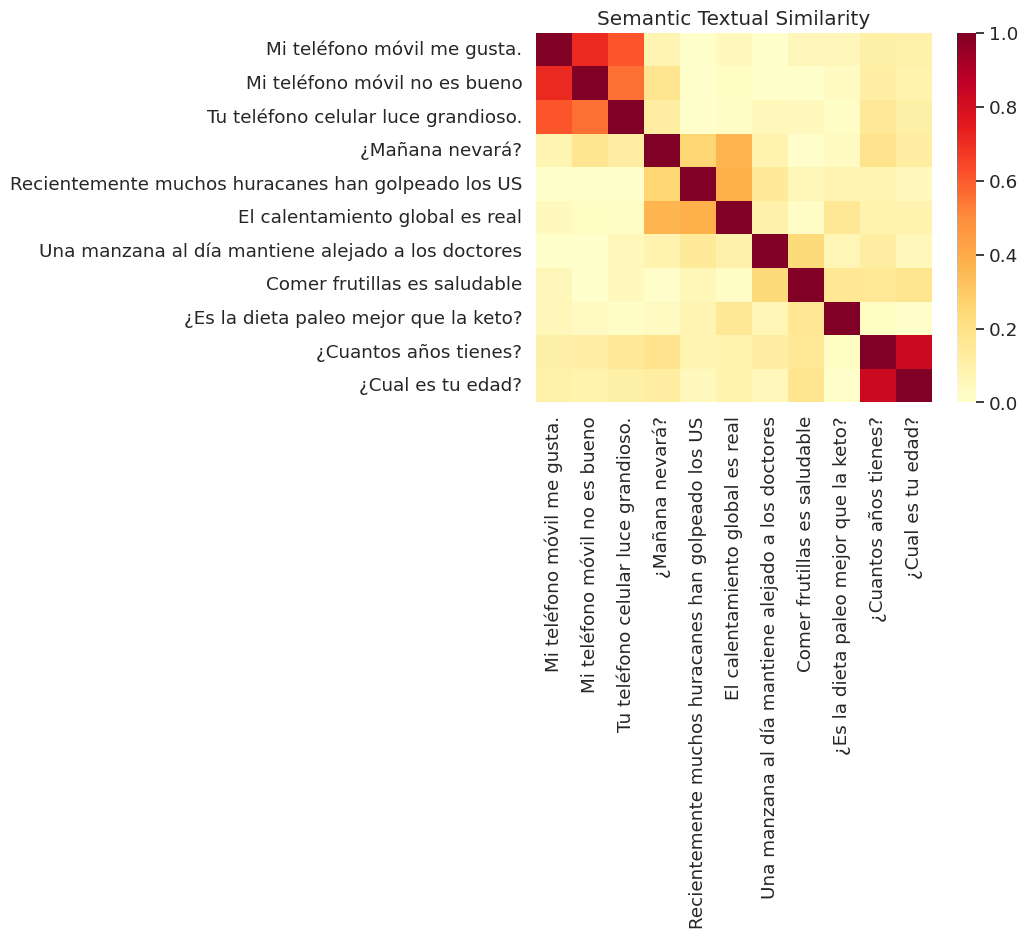

In [ ]:
!pip install sentence_transformers
from sentence_transformers import SentenceTransformer
model = SentenceTransformer("hiiamsid/sentence_similarity_spanish_es")
embeddings_espa2 = []
for t in mensajes:
    emb = list(model.encode(t))
    embeddings_espa2.append(emb)

plot_similarity(mensajes, embeddings_espa2, 90)

### Sentence Transformer (Multimodal)

#### Para el Inglés

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/4.12k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

<Axes: title={'center': 'Semantic Textual Similarity'}>

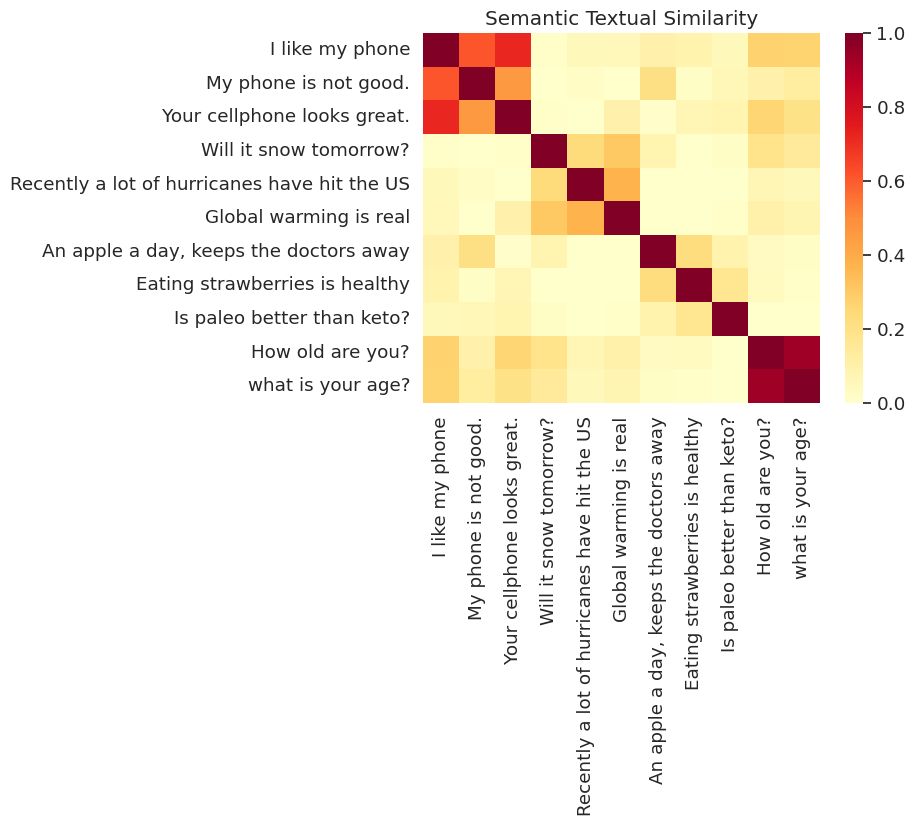

In [ ]:
from sentence_transformers import SentenceTransformer
model_multi = SentenceTransformer("sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2")
embeddings = []
for t in messages:
    emb = list(model_multi.encode(t))
    embeddings.append(emb)

plot_similarity(messages, embeddings, 90)

#### Para el Español

<Axes: title={'center': 'Semantic Textual Similarity'}>

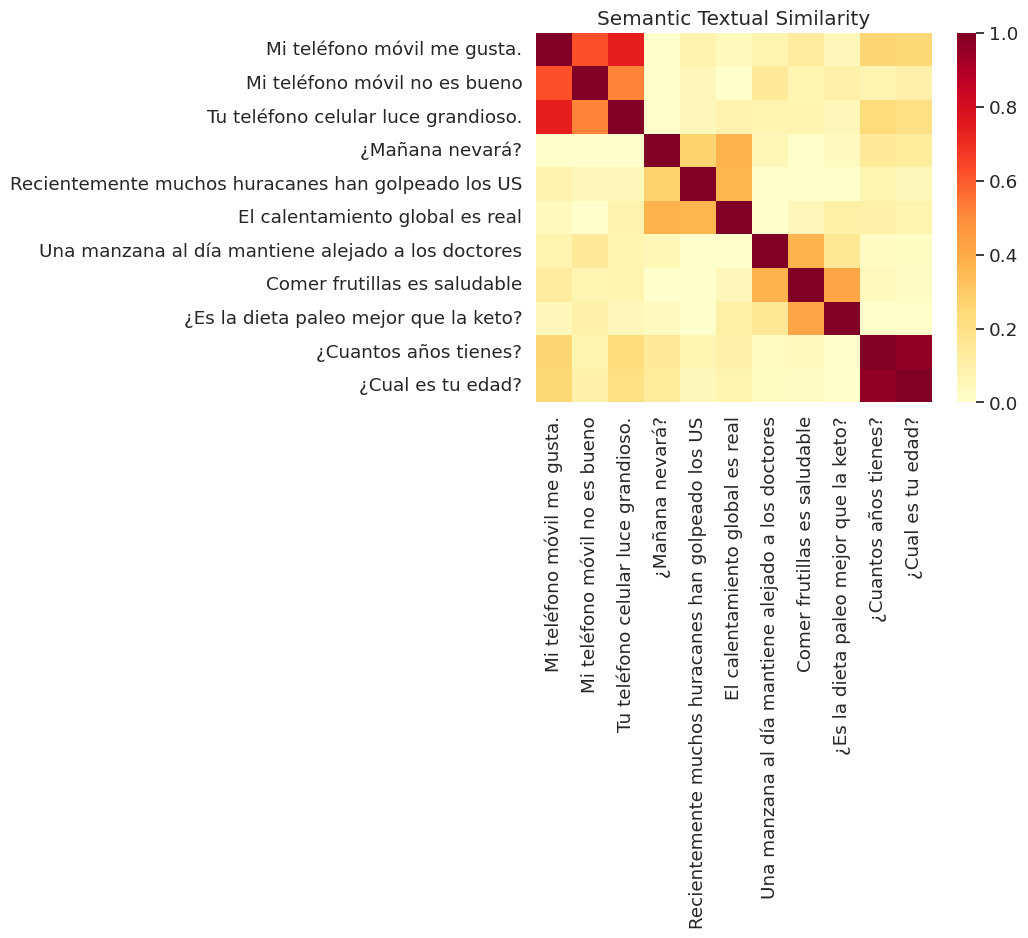

In [ ]:
embeddings = []
for t in mensajes:
    emb = list(model_multi.encode(t))
    embeddings.append(emb)

plot_similarity(mensajes, embeddings, 90)